In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pyfftw
from pyfftw.interfaces.numpy_fft import fftshift
from pyfftw.interfaces.numpy_fft import ifftshift
from pyfftw.interfaces.numpy_fft import rfftn
from pyfftw.interfaces.numpy_fft import irfftn
from pyfftw.interfaces.numpy_fft import rfft2
from pyfftw.interfaces.numpy_fft import irfft2
import scipy as sp
import scipy.ndimage as ndi
import seaborn as sns

from pyem import mrc
from pyem.util import *
from pyem.vop import *

%matplotlib inline
sns.set()
pyfftw.interfaces.cache.enable()

In [87]:
def CTF(N, def1, def2, angast, ps, kv, ac, cs, bf=0, lp=0, phaseshift=0):
    """
    N = pixels of CTF image
    def1/2 = prinicipal defocus values in angstroms (underfocus positive)
    angast = angle from x-axis to azimuth of astigmatism in degrees 
    ps = image pixelsize in angstroms
    kv = acceleration voltage in kilovolts
    ac = amplitude contrast fraction (0-->1)
    cs = spherical aberration in millimeters
    bf = B-factor, divided by 4 in exponential. (negative = lowpass)
    lp = hard low-pass filter, given in angstroms
    """

    kv = kv * 1E3
    cs = cs * 1E7
    a_o = np.deg2rad(angast)
    lamb = 12.2639 / np.sqrt(kv * (1. + kv * .978466E-6))

    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5

    # Constants
    K1 = np.pi / 2. * 2 * lamb
    K2 = np.pi / 2. * cs * lamb**3
    K3 = np.sqrt(1 - ac**2)
    K4 = bf / 4.  # B-factor, follows RELION convention
    K5 = np.deg2rad(phaseshift)  # Phase shift

    nyq = 1. / (2. * ps)
    x, y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
    rho = np.sqrt(x**2 + y**2)
    a = np.arctan2(y, x)
    s = (rho * nyq)

    if lp != 0:
        s[s > (1 / float(lp))] = 0

    s_2 = s**2
    s_4 = s**4

    dZ = def_avg + def_dev * (np.cos(2 * (a - a_o)))
    gamma = (K1 * dZ * s_2) + (K2 * s_4) - K5
    CTF = -(K3 * np.sin(gamma) - ac*np.cos(gamma))

    if bf != 0:
        CTF *= np.exp(-K4 * s_2)

    return CTF

In [15]:
ctf20k_n = lambda x: CTF(x, 20000, 20000, 0, 2.0, 200, 0.1, 2.0, 0, 0)
ctf = CTF(256, 20000, 20000, 0, 2.0, 200, 0.1, 2.0, 0, 0)

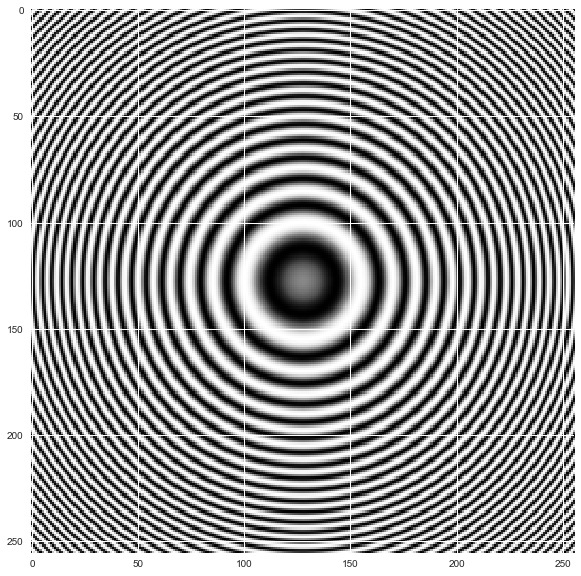

In [42]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(ctf)

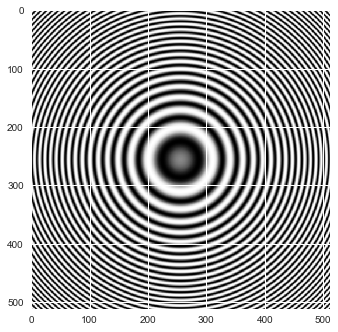

In [43]:
plt.imshow(ctf20k_n(512))

(75, 125)

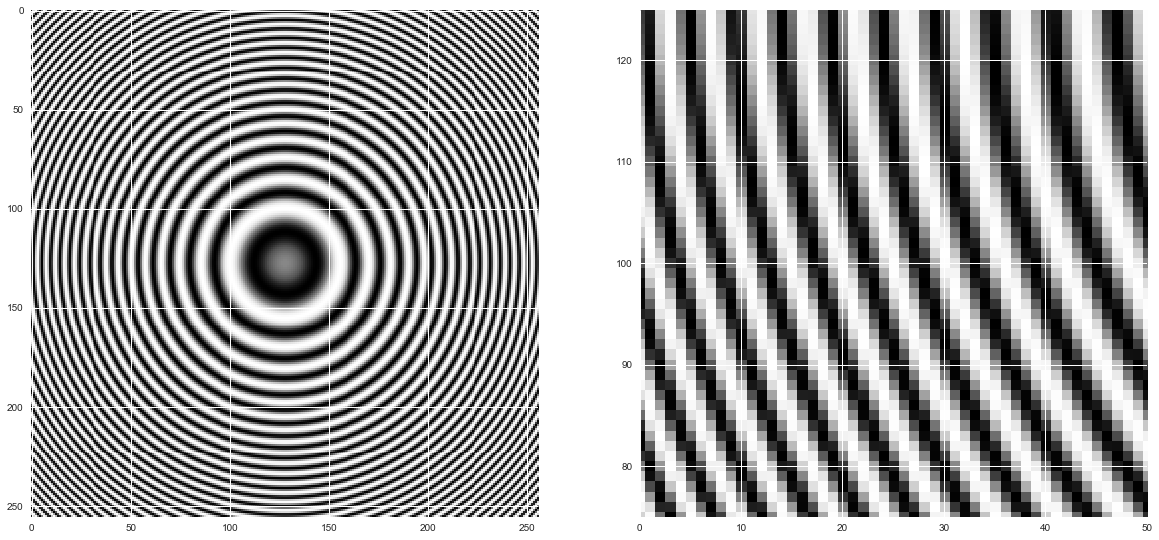

In [11]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(ctf)
ax[1].imshow(ctf)
ax[1].set_xlim((0,50))
ax[1].set_ylim((75, 125))

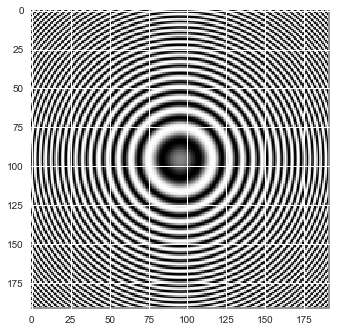

In [38]:
aaf = 10
plt.imshow(ndi.zoom(ndi.zoom(ctf20k_n(192), aaf, order=3), 1./aaf, order=3))

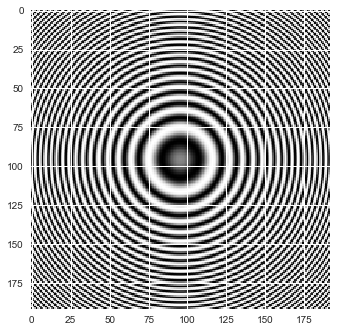

In [39]:
aaf = 1.0
plt.imshow(ndi.zoom(ndi.zoom(ctf20k_n(192), aaf, order=3), 1./aaf, order=3))

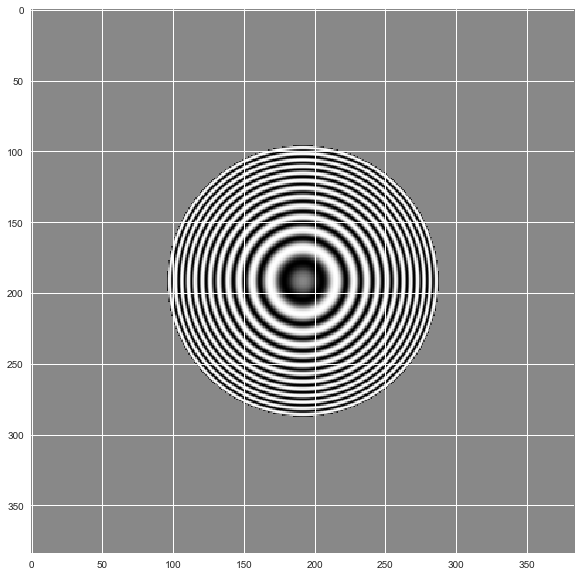

In [69]:
ctf = CTF(384, 20000, 20000, 0, 1.0, 300, 0.1, 2.0, bf=0, lp=4.0)
f, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(ctf)

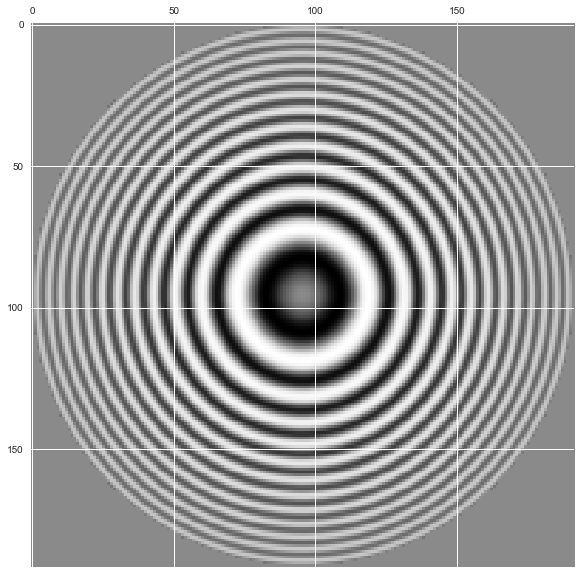

In [80]:
ctf = CTF(192, 20000, 20000, 0, 2.0, 300, 0.1, 2.0, bf=80, lp=4.0)
f, ax = plt.subplots(1, figsize=(10,10))
ax.matshow(ctf)

In [93]:
def ctf_freqs(shape, ps=1.0):
    nyq = 1. / (2. * ps)
    x, y = np.meshgrid(np.linspace(-1, 1, shape[0]), np.linspace(-1, 1, shape[0]))
    rho = np.sqrt(np.su(grid**2, axis=0))
    a = np.arctan2(y, x)
    s = rho * nyq
    return s


def eval_ctf(s, def1, def2, angast=0, phase=0, kv=300, ac=0.1, cs=2.0, bf=0, lp=0):
    """
    :param s: Precomputed frequency grid for CTF evaluation.
    :param def1: 1st prinicipal underfocus distance (Å).
    :param def2: 2nd principal underfocus distance (Å).
    :param angast: Angle of astigmatism (deg) from x-axis to azimuth.
    :param phase: Phase shift (deg).
    :param kv:  Microscope acceleration potential (kV).
    :param ac:  Amplitude contrast in [0, 1.0].
    :param cs:  Spherical aberration (mm).
    :param bf:  B-factor, divided by 4 in exponential, lowpass positive.
    :param lp:  Hard low-pass filter (Å).
    """
    angast = np.deg2rad(angast)
    kv = kv * 1E3
    cs = cs * 1E7
    
    lamb = 12.2639 / np.sqrt(kv * (1. + kv * 0.978466E-6))

    def_avg = -(def1 + def2) * 0.5
    def_dev = -(def1 - def2) * 0.5

    # Constants
    k1 = np.pi / 2. * 2 * lamb
    k2 = np.pi / 2. * cs * lamb**3
    k3 = np.sqrt(1 - ac**2)
    k4 = bf / 4.  # B-factor, follows RELION convention.
    k5 = np.deg2rad(phaseshift)  # Phase shift.

    if lp != 0:
        s[s > (1. / lp)] = 0

    s_2 = s**2
    s_4 = s**4

    dZ = def_avg + def_dev * (np.cos(2 * (a - angast)))
    gamma = (k1 * dZ * s_2) + (k2 * s_4) - k5
    ctf = -(k3 * np.sin(gamma) - ac*np.cos(gamma))

    if bf != 0:
        ctf *= np.exp(-k4 * s_2)

    return ctf